# AR Forecaster

#### Imports

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse_metric
from sklearn.model_selection import KFold
import seaborn as sns

#### data setup

In [86]:
data_directory = '../data/experiment_small/'
data = np.load(data_directory + 'network_params/data_network.npy')
data = np.transpose(data, (1, 2, 0))
data.shape

(4, 2801, 2)

In [87]:
data_train = data[:,:-3*365,:]
data_val = data[:,-3*365:-365,:]
data_test = data[:,-365:,:]

In [88]:
data_train.shape

(4, 1706, 2)

#### data prep

In [89]:
def data_slice(data, h, f):
    T = h + f
    samples = np.array([data[:,t:t + T,:] for t in range(len(data[0]) - T + 1)])
    return samples[:, :, :h, :], samples[:, : , h:, :]

def get_mse(forecast, true_vals):
    N, f , _ = forecast.shape
    forecast = forecast.reshape(N, f * 2)
    true_vals = true_vals.reshape(N, f * 2)
    
    return mse_metric(forecast, true_vals)

#### AR forecaster

In [90]:
def fit_AR_forecaster(hist_samples, future_samples):
  
    m, N, h, _ = hist_samples.shape
    _, _, f, _ = future_samples.shape
    
    hist_sample_matrix = hist_samples.reshape(m * N, h * 2)
    future_sample_matrix = future_samples.reshape(m * N, f * 2)
    
    model = LinearRegression()
    model.fit(hist_sample_matrix, future_sample_matrix)

    return model

def get_AR_forecast(AR_model, history):
    N, h, _ = history.shape
    f = len(AR_model.intercept_)//2
    history = history.reshape(N, 2 * h)

    forecast = AR_model.predict(history)
    return forecast.reshape(N,f,2)
    

#### validation and $h$ hyperparameter fitting

In [91]:
def get_AR_forecast_mse(AR_model, hists, futures):
    _, _, f, _ = futures.shape
    forecasts = np.array([get_AR_forecast(AR_model, hist) for hist in hists])
    mse = np.mean([get_mse(forecasts[i], futures[i]) for i in range(len(futures))])
    return mse

def AR_hyperparam_search(data_train, data_val, h_range, f=3):
    val_mses = []
    for i, h in enumerate(h_range):
        hist_train, future_train = data_slice(data_train, h = h, f = f)
        hist_val, future_val = data_slice(data_val, h = h, f = f)

        AR_model = fit_AR_forecaster(hist_train, future_train)
        val_mses += [get_AR_forecast_mse(AR_model, hist_val, future_val)]
    return val_mses

In [92]:
h_range = np.arange(1,50)
mses_vs_h = AR_hyperparam_search(data_train, data_val, h_range, f=1)

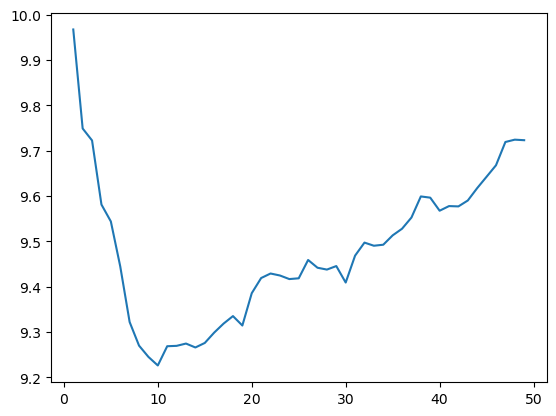

In [93]:
plt.plot(h_range, mses_vs_h)

In [94]:
365/(1706+3*365)

0.1303106033559443